In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [4]:
# Load data
df = pd.read_csv("survey.csv")

In [5]:
# Drop irrelevant or too sparse columns
df = df.drop(columns=["comments", "state", "Timestamp"])

# Drop rows with invalid age
df = df[(df['Age'] > 16) & (df['Age'] < 100)]

# Simplify gender categories
def clean_gender(g):
    g = str(g).lower()
    if 'male' in g:
        return 'Male'
    elif 'female' in g:
        return 'Female'
    else:
        return 'Other'

df['Gender'] = df['Gender'].apply(clean_gender)

# Fill missing values
df = df.fillna('Unknown')

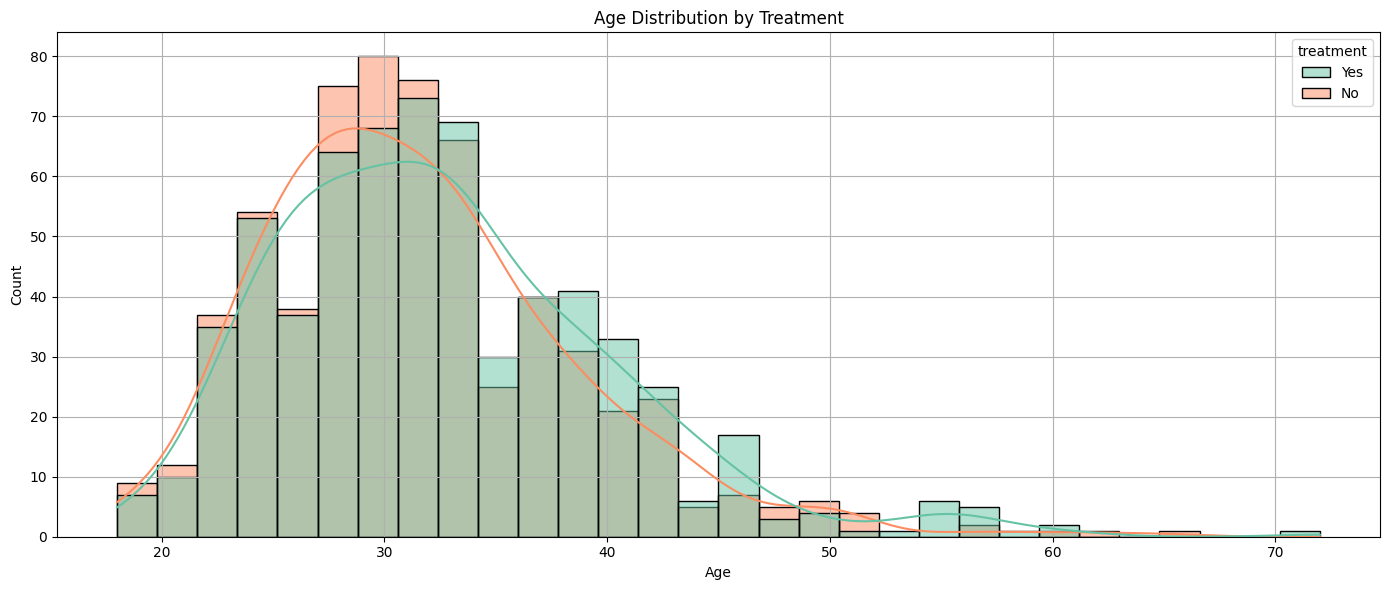

In [6]:
plt.figure(figsize=(14, 6))
sns.histplot(data=df, x='Age', hue='treatment', bins=30, kde=True, palette="Set2")
plt.title('Age Distribution by Treatment')
plt.xlabel('Age')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()

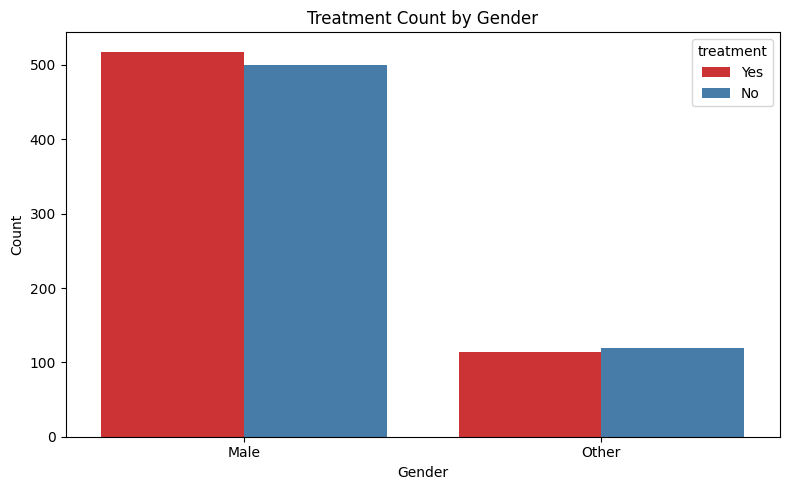

In [7]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Gender', hue='treatment', palette="Set1")
plt.title('Treatment Count by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

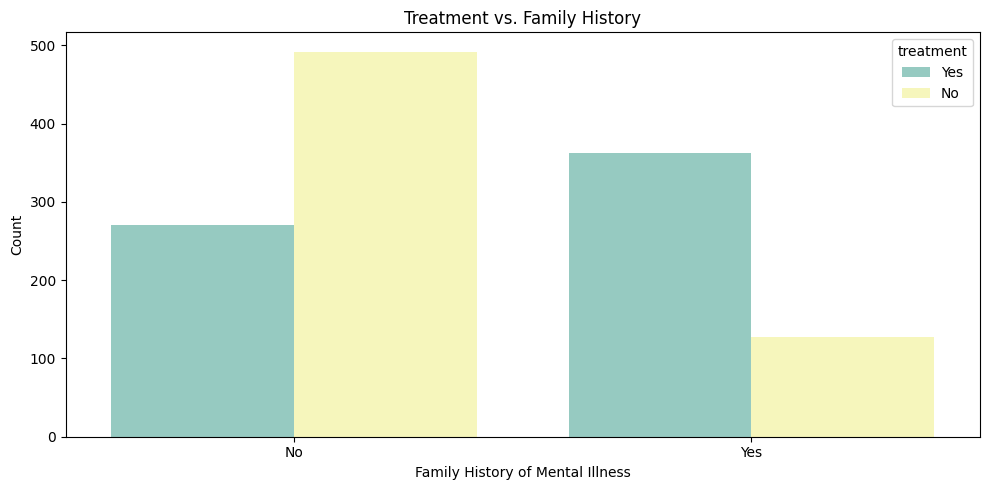

In [8]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='family_history', hue='treatment', palette="Set3")
plt.title('Treatment vs. Family History')
plt.xlabel('Family History of Mental Illness')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

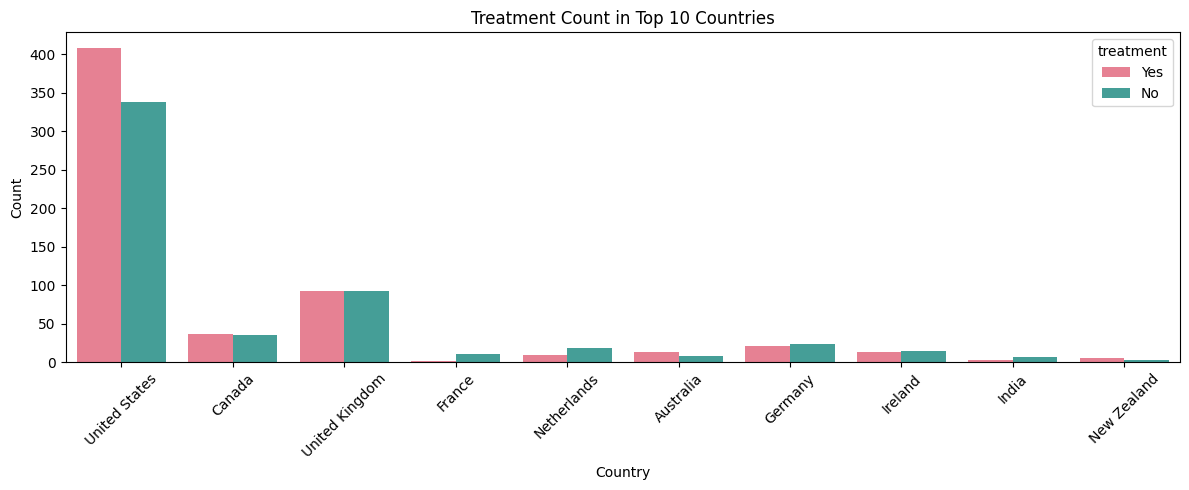

In [9]:
plt.figure(figsize=(12, 5))
top_countries = df['Country'].value_counts().head(10).index
sns.countplot(data=df[df['Country'].isin(top_countries)],
              x='Country', hue='treatment', palette='husl')
plt.title('Treatment Count in Top 10 Countries')
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [10]:
# # Encode categorical features
# categorical_cols = df.select_dtypes(include=['object']).columns
# le = LabelEncoder()
# for col in categorical_cols:
#     df[col] = le.fit_transform(df[col])

categorical_cols = df.select_dtypes(include=['object']).columns
encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

In [11]:
# Feature selection
features = ['Age', 'Gender', 'Country', 'family_history', 'benefits', 'care_options',
            'wellness_program', 'seek_help', 'remote_work', 'work_interfere', 'mental_health_interview']

In [12]:
X = df[features]
y = df['treatment']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
# Model training
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

In [14]:
for name, model in models.items():
    print(f"\n{name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

# Feature importance for RF
rf = models["Random Forest"]
importances = rf.feature_importances_
feature_importance = pd.Series(importances, index=features).sort_values(ascending=False)


Logistic Regression
Confusion Matrix:
 [[81 32]
 [47 91]]
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.72      0.67       113
           1       0.74      0.66      0.70       138

    accuracy                           0.69       251
   macro avg       0.69      0.69      0.68       251
weighted avg       0.69      0.69      0.69       251

ROC AUC Score: 0.688117224573554

Random Forest
Confusion Matrix:
 [[ 83  30]
 [ 26 112]]
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.73      0.75       113
           1       0.79      0.81      0.80       138

    accuracy                           0.78       251
   macro avg       0.78      0.77      0.77       251
weighted avg       0.78      0.78      0.78       251

ROC AUC Score: 0.773053738617417


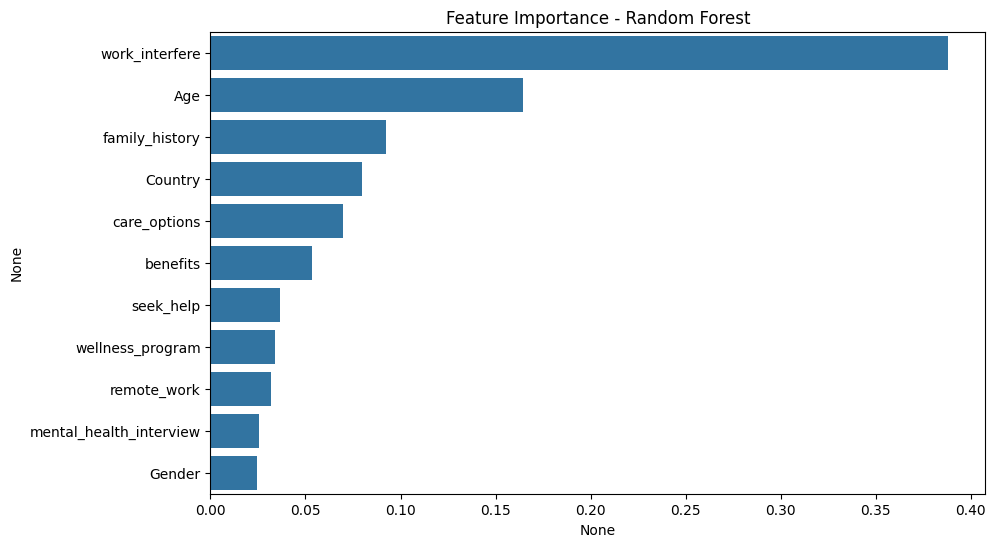

In [15]:
plt.figure(figsize=(10,6))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title('Feature Importance - Random Forest')
plt.show()

In [17]:
# pickle.dump(model, open("model.pkl", "wb"))
# pickle.dump(scaler, open("scaler.pkl", "wb"))
# pickle.dump(encoders, open("encoders.pkl", "wb"))

import pickle
best_model = models["Random Forest"]
pickle.dump(best_model, open("model.pkl", "wb"))
pickle.dump(scaler, open("scaler.pkl", "wb"))
pickle.dump(encoders, open("encoders.pkl", "wb"))

In [18]:
import json
with open("features.json", "w") as f:
    json.dump(features, f)